In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
from skopt import BayesSearchCV

In [2]:
Kepler = pd.read_csv("Kepler.csv", skiprows=53)

# Cleaning

### Drop & Rename Columns

In [5]:
cols_drop = ["kepid", "kepoi_name", "kepler_name", "koi_pdisposition",
             "koi_tce_delivname","koi_score","koi_tce_plnt_num"]
Kepler.drop(cols_drop, axis=1, inplace=True)

In [6]:
Kepler.rename({"koi_disposition":"Labels"}, inplace=True, axis=1)

### Drop Empty Rows 

In [8]:
Kepler.dropna(how="all", inplace=True)

### Drop Columns with too many NaNs

In [10]:
n_nans = 9000
which_nan = []

for col in Kepler.columns.to_list():
    n = Kepler[col].isnull().sum().sum()
    if n > n_nans:
        which_nan.append(col)
print(which_nan)  

['koi_teq_err1', 'koi_teq_err2']


In [11]:
Kepler.drop(which_nan, axis=1, inplace=True)

### Drop Duplicate Rows

In [13]:
Kepler.drop_duplicates(inplace=True, keep="first")

### Drop Columns with the same value for every row

In [15]:
which_0 = []

for col in Kepler.columns:
    if Kepler[col].nunique() == 1:
        which_0.append(col)
print(which_0)

[]


In [16]:
Kepler.drop(which_0, axis=1, inplace=True)

### Drop Perfectly Correlated Error Columns

In [18]:
problem_cols = []
for col in Kepler.columns:
    if "err1" in col:
        partner_col = col.replace("1", "2")
        if partner_col in Kepler.columns:
            problem_cols.append([col, partner_col])
print("Pairs found:", problem_cols)

for col1, col2 in problem_cols:
    # Check if partner column actually exists
    if col2 not in Kepler.columns:
        print(f"Skipping {col1} — missing partner column {col2}")
        continue

    n_nan1 = Kepler[col1].isna().sum()
    n_nan2 = Kepler[col2].isna().sum()

    # Check if they have different numbers of NaN
    if n_nan1 != n_nan2:
        print(f"Skipping {col1}, {col2}: different number of NaN ({n_nan1} vs {n_nan2})")
        continue

    # Compare only where both are not NaN
    mask = Kepler[col1].notna() & Kepler[col2].notna()
    if (Kepler.loc[mask, col1] == -Kepler.loc[mask, col2]).all():
        Kepler.drop(col2, axis=1, inplace=True)
        print(f"Dropped {col2} (exact negative of {col1})")
    else:
        print(f"{col2} is not the exact negative of {col1}")




Pairs found: [['koi_period_err1', 'koi_period_err2'], ['koi_time0bk_err1', 'koi_time0bk_err2'], ['koi_impact_err1', 'koi_impact_err2'], ['koi_duration_err1', 'koi_duration_err2'], ['koi_depth_err1', 'koi_depth_err2'], ['koi_prad_err1', 'koi_prad_err2'], ['koi_insol_err1', 'koi_insol_err2'], ['koi_steff_err1', 'koi_steff_err2'], ['koi_slogg_err1', 'koi_slogg_err2'], ['koi_srad_err1', 'koi_srad_err2']]
Dropped koi_period_err2 (exact negative of koi_period_err1)
Dropped koi_time0bk_err2 (exact negative of koi_time0bk_err1)
koi_impact_err2 is not the exact negative of koi_impact_err1
Dropped koi_duration_err2 (exact negative of koi_duration_err1)
Dropped koi_depth_err2 (exact negative of koi_depth_err1)
koi_prad_err2 is not the exact negative of koi_prad_err1
koi_insol_err2 is not the exact negative of koi_insol_err1
Skipping koi_steff_err1, koi_steff_err2: different number of NaN (468 vs 483)
koi_slogg_err2 is not the exact negative of koi_slogg_err1
koi_srad_err2 is not the exact negativ

# TDA

In this section we apply a novel feature engineering technique which has been used in Neurobiology for the last two decades but has not been implemented 
in Space-related research so far. It based on advanced pure mathematics. In particular, it is based on Topology. It basically captures signals that classical techniques
cannot, known as Topological Invariants.

In [21]:
# Step 0: Keep labels aside and store original data
labels = Kepler["Labels"].copy()
Kepler_numeric = Kepler.drop("Labels", axis=1).copy()  # numeric features, may contain NaNs

# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

# giotto-tda
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, BettiCurve

# Step 2: Temporary KNN imputation for TDA computation
imputer = KNNImputer(n_neighbors=5)  # can tune neighbors
X_imputed = imputer.fit_transform(Kepler_numeric.values)

# Step 3: Scale the imputed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 4: Build nearest neighbor search
k = 30
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_scaled)

# Step 5: Extract neighborhoods as point clouds
neighborhoods = []
for i in range(X_scaled.shape[0]):
    distances, indices = nn.kneighbors(X_scaled[i].reshape(1, -1))
    local_cloud = X_scaled[indices[0]]  # (k, n_features)
    neighborhoods.append(local_cloud)

neighborhoods = np.array(neighborhoods)  # shape (n_samples, k, n_features)


# Step 6: Compute persistence diagrams
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], metric="euclidean")
diagrams = VR.fit_transform(neighborhoods)

# Step 7a: Persistence Entropy
PE = PersistenceEntropy()
entropy_features = PE.fit_transform(diagrams)

# Step 7b: Total Persistence
def total_persistence(diagrams):
    totals = []
    for diag in diagrams:
        row = []
        for dim in [0, 1]:
            mask = diag[:, 2] == dim
            lifetimes = diag[mask, 1] - diag[mask, 0]
            row.append(lifetimes.sum())
        totals.append(row)
    return np.array(totals)

total_features = total_persistence(diagrams)

# Step 8: Combine all TDA features
tda_features_combined = np.hstack([entropy_features, total_features])
tda_feature_names = (
    [f"tda_entropy_dim{i}" for i in range(entropy_features.shape[1])] +
    [f"tda_total_dim{i}" for i in range(total_features.shape[1])]
)
tda_df = pd.DataFrame(tda_features_combined, columns=tda_feature_names)

# Step 9: Concatenate TDA features with original dataset (including NaNs)
Kepler = pd.concat([labels.reset_index(drop=True), Kepler_numeric.reset_index(drop=True), tda_df.reset_index(drop=True)], axis=1)

# Cross-Validation

In [23]:
# Separate features (x) and labels (y)
x = Kepler.drop("Labels", axis=1) # only features
y = Kepler["Labels"] # only label

In [24]:
# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [25]:
# Split in train and test data
x_train, x_test, y_train, y_test = train_test_split( x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42 )

In [26]:
#from sklearn.metrics import make_scorer, recall_score
#recall_scorer = make_scorer(recall_score, average='macro')

In [27]:
# Make the model:
xgb = XGBClassifier(objective="multi:softmax",num_class=len(le.classes_), eval_metric="mlogloss", random_state=42)

# Define the range of search (ranges, no lists)
search_spaces = {
    "n_estimators": (100, 1200),      
    "learning_rate": (0.001, 1, "log-uniform"),
    "max_depth": (3, 15),
    "subsample": (0.3, 1.0, "uniform"),
    "colsample_bytree": (0.3, 1.0, "uniform")
}

# Search optimal parameters for the model and do cross validation
bayes = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,   
    cv=3,
    n_jobs=-1,
    scoring="recall_macro",
    verbose=1,
    random_state=42
)
# Fit the model
bayes.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, feature_weights=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constrai...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_class=3, ...),
              n_jobs=-1, random_state=42, scoring='recall_macro',
              search_spaces={'colsample_bytree': (0.3, 1.0, 'uniform'),
                             'learning_rate': (0.001, 1, 'log-uniform'),
                             'max_depth': (3, 15), 'n_estimators': (100, 1200),
                             'subsample': (0.3, 1.0, 'uniform')},
              verbose=1)

In [28]:
print("Best parameters:", bayes.best_params_)
print("Best score:", bayes.best_score_)

Best parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.04210382458560936, 'max_depth': 15, 'n_estimators': 466, 'subsample': 1.0})
Best score: 0.9017136170986665


In [29]:
# After the search we have the best model:
best_model = bayes.best_estimator_

#Predictions, test and scoring 
y_pred = best_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9262937794040773
Classification report:
                 precision    recall  f1-score   support

     CANDIDATE       0.82      0.83      0.83       396
     CONFIRMED       0.90      0.89      0.89       549
FALSE POSITIVE       0.99      0.98      0.99       968

      accuracy                           0.93      1913
     macro avg       0.90      0.90      0.90      1913
  weighted avg       0.93      0.93      0.93      1913

Confusion matrix:
 [[330  57   9]
 [ 57 490   2]
 [ 16   0 952]]


<Figure size 1000x600 with 0 Axes>

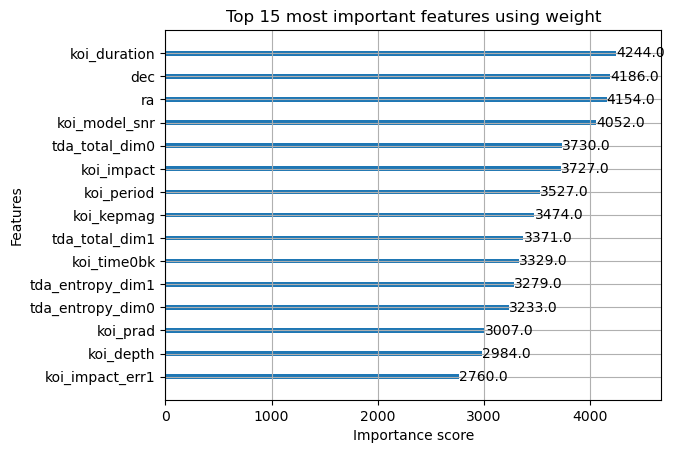

In [30]:
# Top 15 most important features using weight
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15)
plt.title("Top 15 most important features using weight")
plt.show()

<Figure size 1000x600 with 0 Axes>

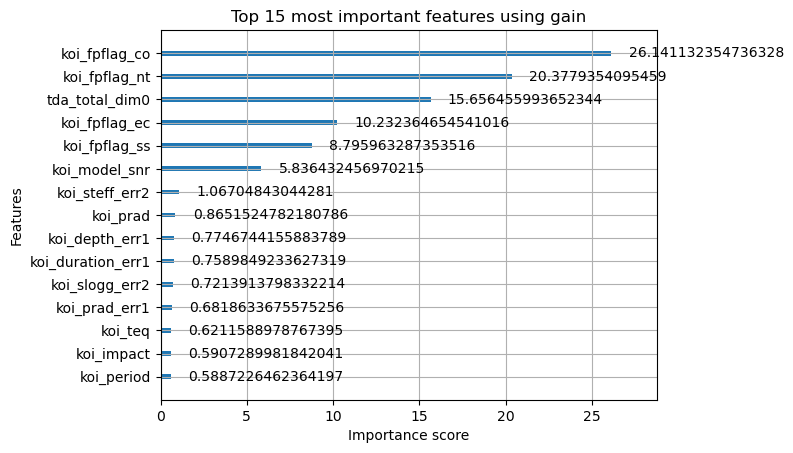

In [31]:
# Top 15 most important features using gain
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15,importance_type="gain")
plt.title("Top 15 most important features using gain")
plt.show()

### Save the Model

In [54]:
import joblib

In [56]:
joblib.dump(best_model, "kepler_model.pkl")

['kepler_model.pkl']